In [2]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import mplhep as hep
#hep.style.use(hep.style.ROOT)

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



In [3]:
path_i= "/eos/home-r/ramellar/5_inputs/"
path_p= "/eos/home-r/ramellar/4_classification/classification_predictions/"

new= path_i + "signal_region/2b_data_full_stats/output_JetGood_test.h5"
old= path_i + "2b_data_full_statistics_c/output_JetGood_test.h5"
pred= path_p + "spanet_c_pred_training_inclusive_2b_data_f_eval_sr_2b_data_full_stats_dnn.h5"

df_new= h5py.File(new, "r")
df_old=h5py.File(old, "r")
df_pred= h5py.File(pred, "r")

print(len(df_old["CLASSIFICATIONS"]['EVENT']['signal']))
print(len(df_new["CLASSIFICATIONS"]['EVENT']['signal']))


1342161
202999


In [4]:
def probabilities(test, prediction, name, title):
    filename_test= path_i + test
    df_test= h5py.File(filename_test, "r")
    filename_pred= path_p + prediction
    df_pred= h5py.File(filename_pred, "r")
    
    mask_signal=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    prob_signal=df_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    proba_signal_signal=prob_signal[mask_signal]
    proba_signal_background=prob_signal[mask_background]
    weights_signal= df_test["WEIGHTS"]['weight'][()][mask_signal]
    print("dataset", df_test)
    print("bckg", len(proba_signal_background))
    print("signal", len(proba_signal_signal))
    weights_bckg= df_test["WEIGHTS"]['weight'][()][mask_background]
    print(weights_bckg)
    fig= plt.figure()
    plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal", density=True)
    plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background", density=True)
    plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.title(f"{title}")
    plt.legend()
    # plt.yscaçle("log")
    plt.show()
    # plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/classification_plots/signal_proba_{name}")
    # plt.close(fig)
    return proba_signal_signal, proba_signal_background

dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 1994
signal 108131
[1.6318968e-07 6.1479079e-07 1.6369896e-07 ... 1.8863133e-05 1.6191017e-07
 6.0914493e-07]


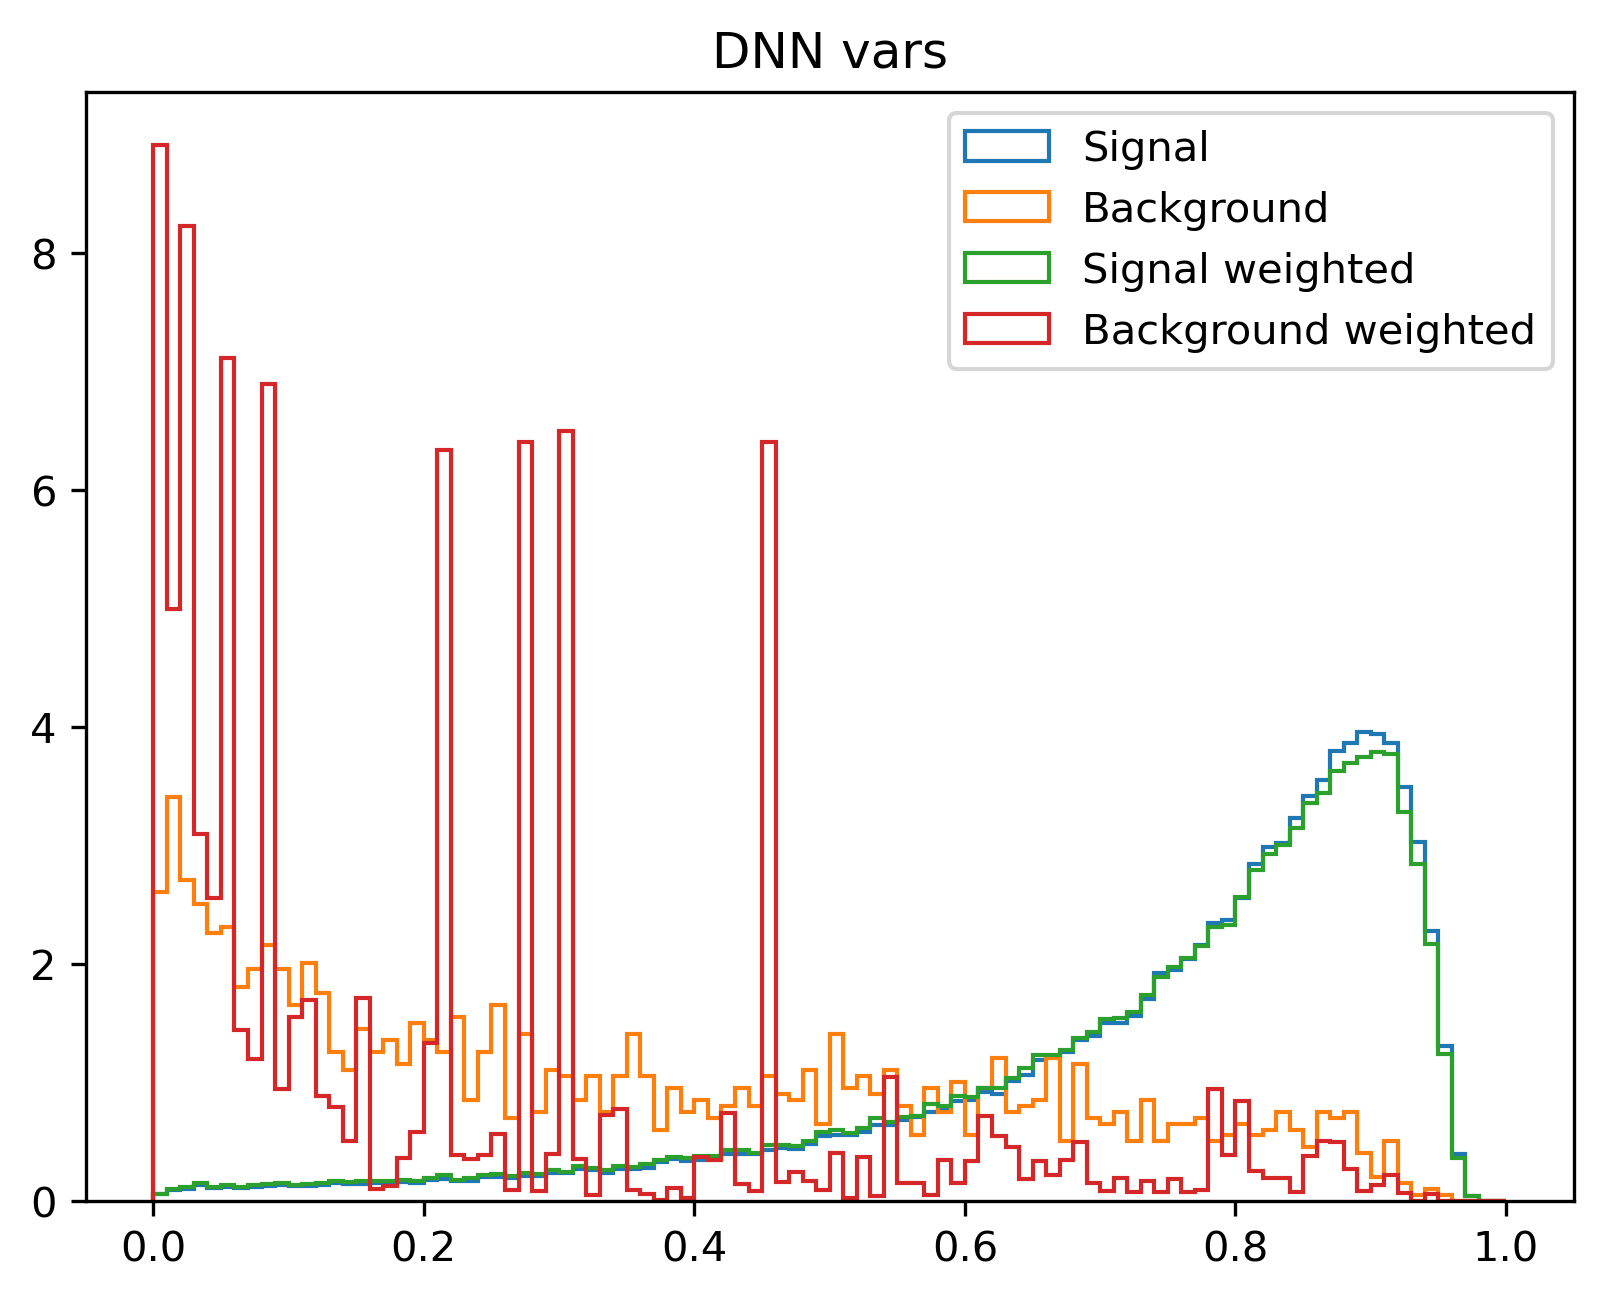

dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 1994
signal 108131
[1.6318968e-07 6.1479079e-07 1.6369896e-07 ... 1.8863133e-05 1.6191017e-07
 6.0914493e-07]


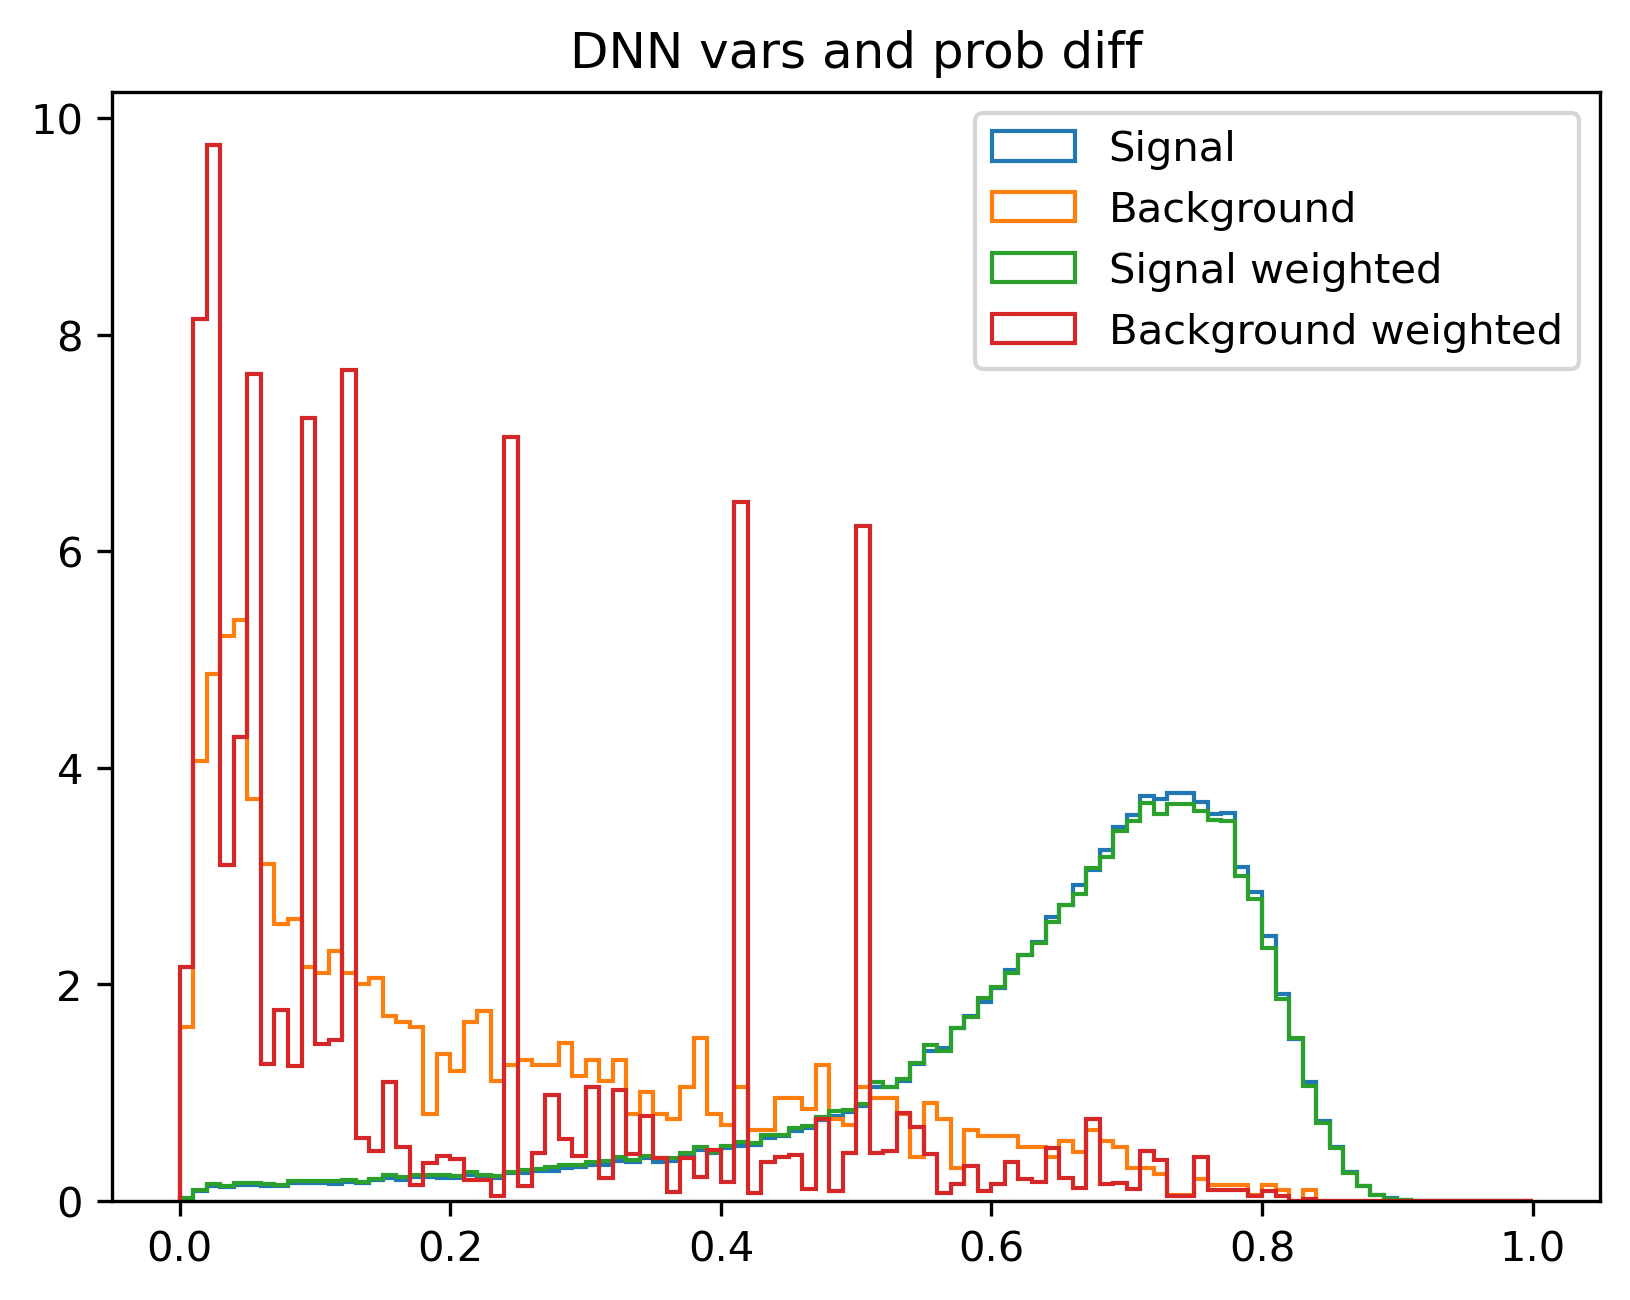

dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24468
signal 159249
[6.6404986e-08 1.6274313e-07 2.7102376e-06 ... 1.6169162e-07 6.6447107e-08
 2.6948323e-06]


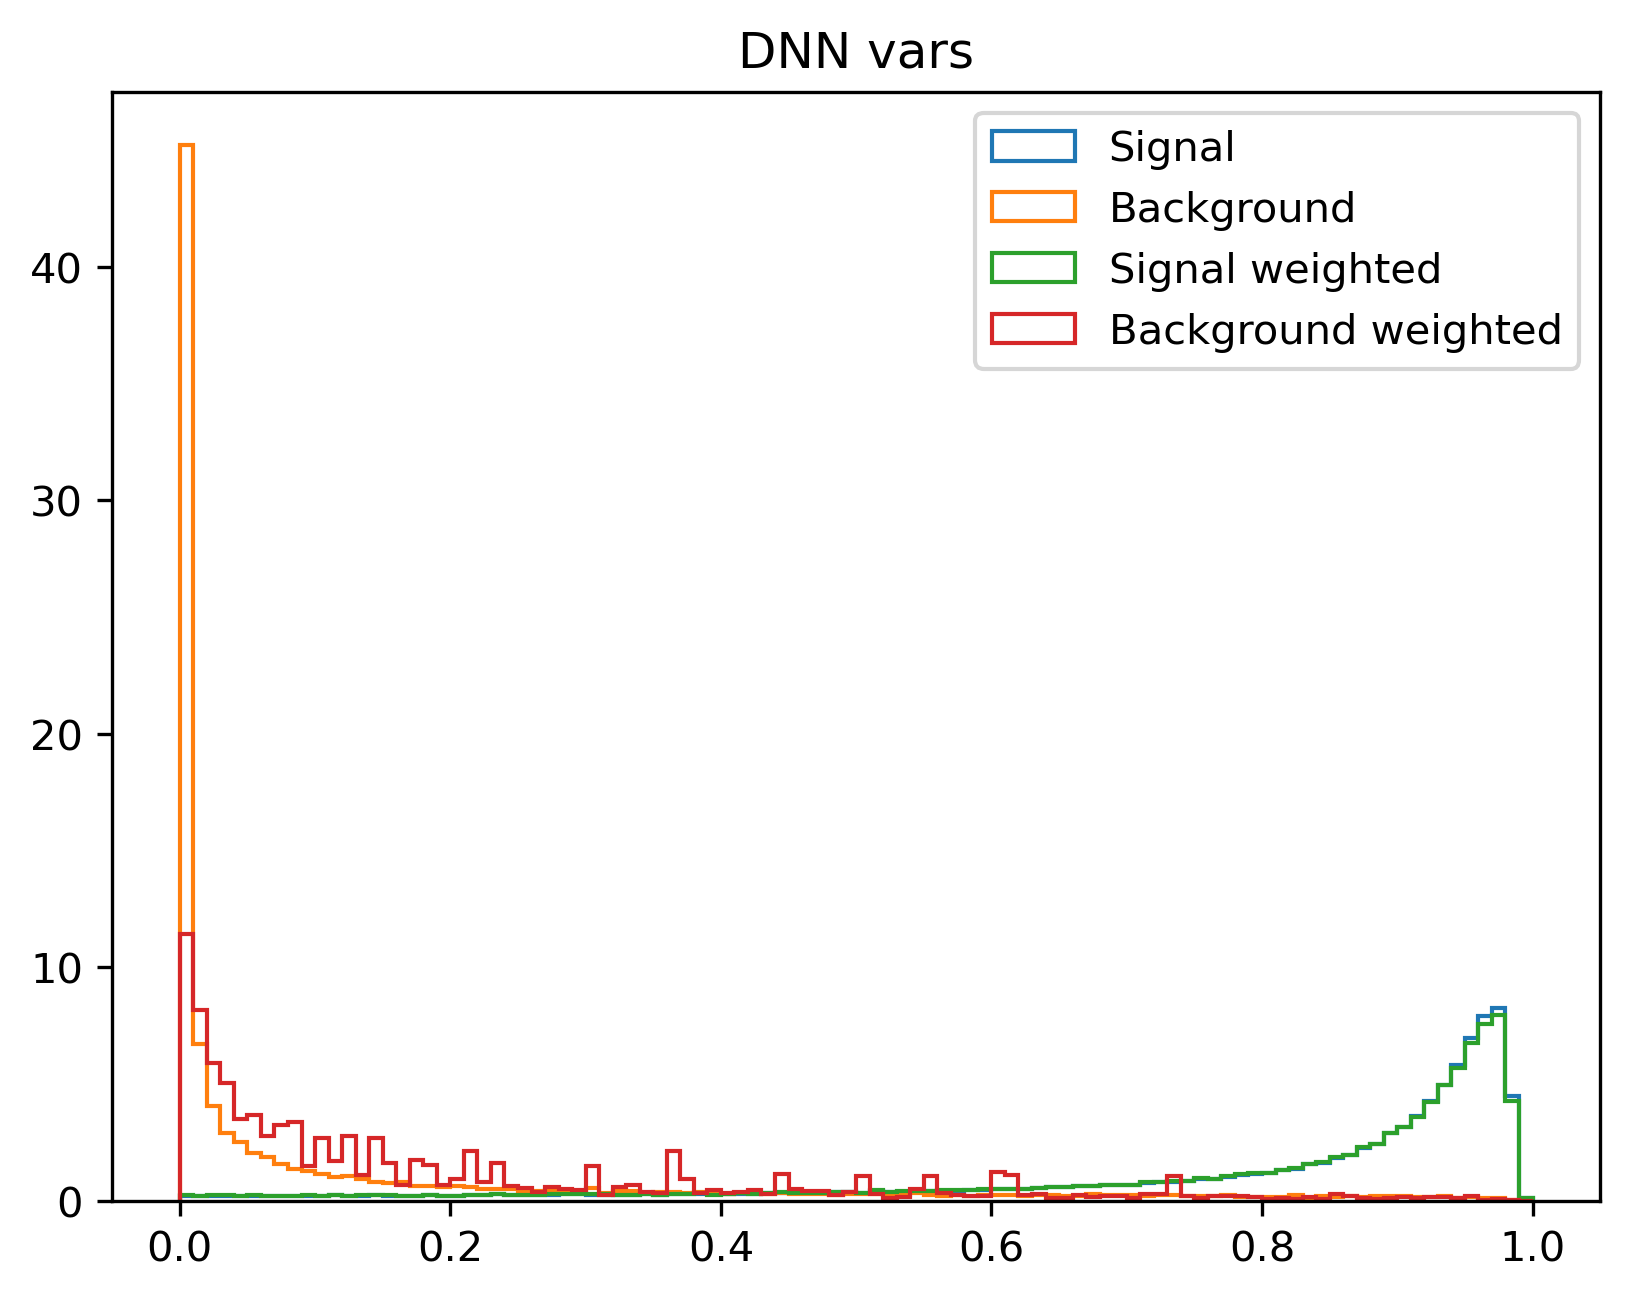

dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24468
signal 159249
[6.6404986e-08 1.6274313e-07 2.7102376e-06 ... 1.6169162e-07 6.6447107e-08
 2.6948323e-06]


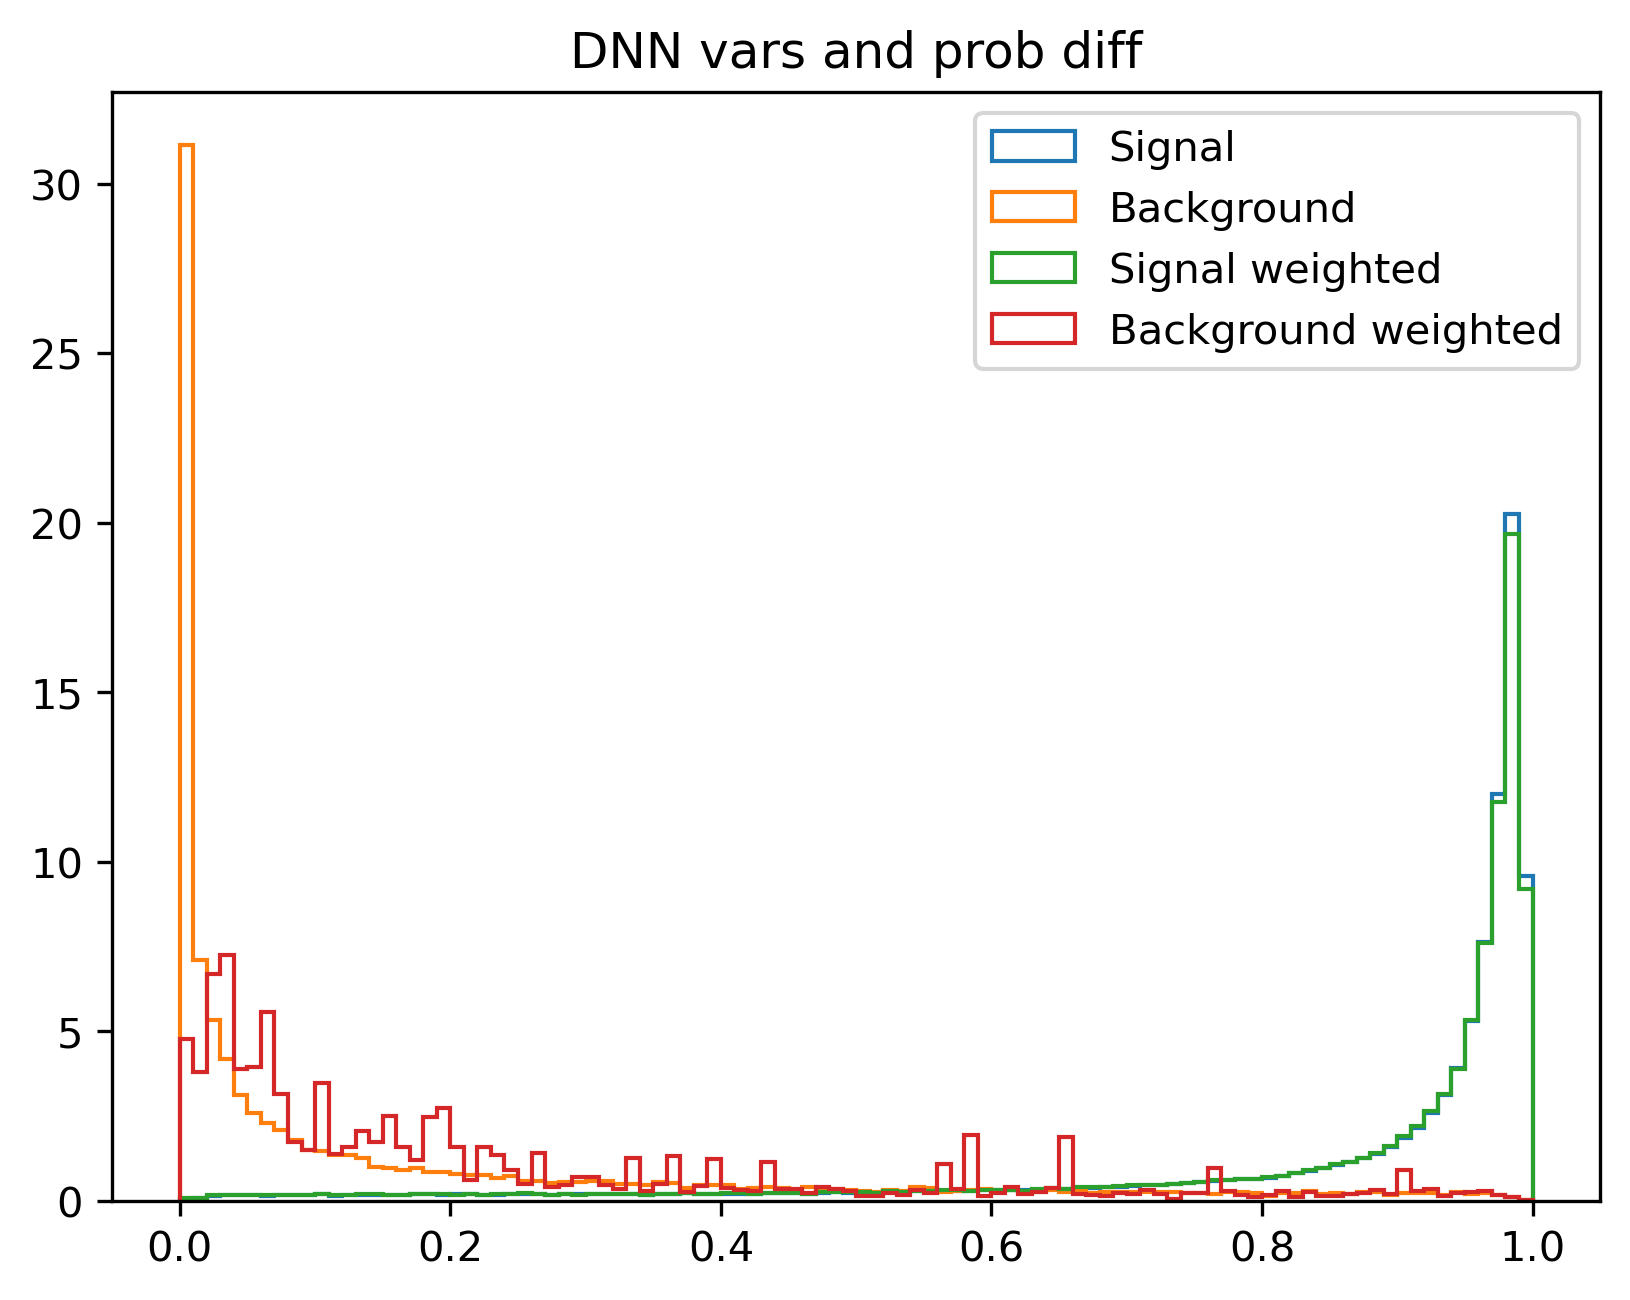

(array([0.98182684, 0.84122217, 0.97886705, ..., 0.8863617 , 0.9827299 ,
        0.93481666], dtype=float32),
 array([7.9419661e-01, 6.0172933e-01, 6.2928778e-01, ..., 2.2391769e-01,
        1.2373309e-04, 8.9977109e-01], dtype=float32))

In [17]:
probabilities("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn.h5", "whate", "DNN vars")
probabilities("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn_proba.h5", "whate", "DNN vars and prob diff")
probabilities("spanet_classifier_4b_QCD_working/output_JetGood_test.h5", "spanet_c_pred_4b_QCD_dnn.h5", "4b_QCD_dnn", "DNN vars")
probabilities("spanet_classifier_4b_QCD_working/output_JetGood_test.h5", "spanet_c_pred_4b_QCD_dnn_proba.h5", "4b_QCD_dnn_proba", "DNN vars and prob diff")


In [10]:
def diff_proba_weights_comparison(test ,prediction , name, title):
    
    filename_test= path_i + test
    dataset_test= h5py.File(filename_test, "r")
    filename_pred= path_p + prediction
    dataset_pred= h5py.File(filename_pred, "r")
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    diff_proba_signal=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
    diff_proba_bckg=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
    
    # for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
    weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    # print("weights_bckg", weights_bckg)
    
    fig = plt.figure()
    plt.hist(diff_proba_signal,bins=40,range=(-0.25,1.1),histtype='step',label="Signal", density=True)
    plt.hist(diff_proba_bckg,bins=40,range=(-0.25,1.1),histtype='step',label="Background", density=True)
    plt.hist(diff_proba_signal,bins=40,range=(-0.25,1.1),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(diff_proba_bckg,bins=40,range=(-0.25,1.1),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.legend(loc='upper right', fontsize="x-small")
    plt.xlabel(r"$\Delta$ Probability")
    plt.yscale("log")
    plt.ylabel("Normalized counts")
    plt.title(f"Probability difference {title}")
    plt.grid(linestyle=":")
    plt.savefig(f"probability_diff_{name}")
    plt.close(fig)
    return diff_proba_signal, diff_proba_bckg

In [19]:
diff_proba_weights_comparison("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn.h5", "4b_QCD_sr_dnn",  "variable distribution")
# diff_proba_weights_comparison("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn_proba.h5", "4b_QCD_sr_dnn_proba", "DNN vars and prob diff for 4b QCD in sr")
diff_proba_weights_comparison("spanet_classifier_4b_QCD_working/output_JetGood_test.h5", "spanet_c_pred_4b_QCD_dnn.h5", "4b_QCD_dnn", "variable distribution")
# diff_proba_weights_comparison("spanet_classifier_4b_QCD_working/output_JetGood_test.h5", "spanet_c_pred_4b_QCD_dnn_proba.h5", "4b_QCD_dnn_proba", "DNN vars and prob diff")


(array([0.99856204, 0.971255  , 0.9691507 , ..., 0.9843092 , 0.99994284,
        0.9996856 ], dtype=float32),
 array([0.986216  , 0.9999296 , 0.942777  , ..., 0.03557604, 0.08411165,
        0.994228  ], dtype=float32))

In [13]:
def diff_proba_weights_comparison_arc_tan(test ,prediction , name, title):
    
    filename_test= path_i + test
    dataset_test= h5py.File(filename_test, "r")
    filename_pred= path_p + prediction
    dataset_pred= h5py.File(filename_pred, "r")
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
    diff_proba_bckg=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
    
    # for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
    weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    # print("weights_bckg", weights_bckg)
    
    fig = plt.figure()
    plt.hist(diff_proba_signal,bins=40,range=(0,8),histtype='step',label="Signal", density=True)
    plt.hist(diff_proba_bckg,bins=40,range=(0,8),histtype='step',label="Background", density=True)
    plt.hist(diff_proba_signal,bins=40,range=(0,8),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(diff_proba_bckg,bins=40,range=(0,8),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.legend(loc='upper right', fontsize="x-small")
    plt.xlabel(r"$\Delta$ Probability")
    plt.yscale("log")
    plt.ylabel("Normalized counts")
    plt.title(f"Probability difference {title}")
    plt.grid(linestyle=":")
    plt.savefig(f"probability_diff_{name}_arc_tan")
    plt.close(fig)
    return diff_proba_signal, diff_proba_bckg

In [15]:
diff_proba_weights_comparison_arc_tan("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn.h5", "4b_QCD_sr_dnn", "DNN vars")
diff_proba_weights_comparison_arc_tan("signal_region/signal_region_4b_QCD/output_JetGood_test.h5", "spanet_pred_c_4b_QCD_sr_dnn_proba.h5", "4b_QCD_sr_dnn_proba", "DNN vars and prob diff")


/tmp/ramellar/ipykernel_640678/819942594.py:11: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_bckg=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
/tmp/ramellar/ipykernel_640678/819942594.py:11: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_bckg=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])


(array([3.618478 , 2.0781221, 3.2930558, ..., 4.343136 , 5.23138  ,
        4.3788943], dtype=float32),
 array([0.54099137, 1.1867108 , 1.6461298 , ..., 0.6909723 , 1.2567437 ,
        0.649386  ], dtype=float32))

In [20]:
def threshold_value_min(efficiency, tpr, thresholds):
    min_eff=efficiency
    mask_sig_eff=tpr>= min_eff
    min_ind= np.argwhere(tpr==np.min(tpr[mask_sig_eff]))
    index=min_ind[0][0]
    threshold_eff =thresholds[index]
    return threshold_eff

def threshold_value_max(efficiency, tpr, thresholds):
    min_eff=efficiency
    mask_sig_eff=tpr>= min_eff
    min_ind= np.argwhere(tpr==np.min(tpr[mask_sig_eff]))
    index=min_ind[-1][0]
    threshold_eff =thresholds[index]
    return threshold_eff

In [35]:
def thresholds_check(prediction, test, min_eff, max_eff, prob_diff=None):
    filename_test= path_i + test
    dataset_test= h5py.File(filename_test, "r")
    filename_pred= path_p + prediction
    dataset_pred= h5py.File(filename_pred, "r")
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    
    if prob_diff is None:
        
        prob_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        proba_signal_signal=prob_signal[mask_signal]
        proba_signal_background=prob_signal[mask_background]
        true= dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
        weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
        weights=dataset_test["WEIGHTS"]['weight'][()]

        
        print("max",np.max(prob_signal))
        print("min",np.min(prob_signal))

        fpr, tpr, thresholds= roc_curve(true, prob_signal, sample_weight= weights)
        score=roc_auc_score(true,prob_signal, sample_weight= weights )
        
        min_eff=0.900
        max_eff=1

        th_minp=threshold_value_min(min_eff,tpr,thresholds)
        th_100p=threshold_value_max(max_eff,tpr,thresholds)
        
        
        plt.figure()
        plt.plot(tpr, fpr, label=f"AUC={score:.3f}")
        # plt.plot(tpr[mask_min & mask_max], fpr[mask_min & mask_max])
        plt.axvline(x=min_eff, color='r', linestyle='--', label=f'{min_eff} eff of the signal')
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.grid(linestyle=":")
        plt.legend()
        plt.show()

        plt.show()
        plt.hist(proba_signal_signal,bins=40,range=(0,1),histtype='step',label="Signal weighted", weights=weights_signal,density=True)
        plt.hist(proba_signal_background,bins=40,range=(0,1),histtype='step',label="Background weighted", weights=weights_bckg,density=True)
        plt.hist(proba_signal_signal,bins=40,range=(0,1),histtype='step',label="Signal",density=True)
        plt.hist(proba_signal_background,bins=40,range=(0,1),histtype='step',label="Background", density=True)
        plt.axvline(x=(th_minp), color='r', linestyle='--', label=f'{min_eff} eff of the signal')
        # plt.axvline(x=th_100p, color='g', linestyle='--', label=f'{max_eff} eff of the signal')

        # plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
        # plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
        plt.legend(loc='upper right', fontsize="x-small")
        plt.xlabel(r"$\Delta$ Probability")
        # plt.yscale("log")
        plt.title(f"Probability difference")
        plt.grid(linestyle=":")
        plt.show()

    
    else:     
        true= dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]

        diff_proba_signal=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
        diff_proba_bckg=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])

        
        diff_proba= dataset_pred["INPUTS"]["Event"]["Probability_difference"][()]

        # for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
        weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
        weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
        weights=dataset_test["WEIGHTS"]['weight'][()]
        
    

        print("max",np.max(diff_proba))
        print("min",np.min(diff_proba))

        fpr, tpr, thresholds= roc_curve(true, diff_proba, sample_weight= weights)
        
        min_eff=0.900
        max_eff=1

        th_80p=threshold_value_min(min_eff,tpr,thresholds)
        th_100p=threshold_value_max(max_eff,tpr,thresholds)

        print(np.sum(diff_proba<=th_100p))

        mask_min=tpr > min_eff
        mask_max = tpr < max_eff

        score=roc_auc_score(true,diff_proba, sample_weight= weights )


        plt.figure()
        plt.plot(tpr, fpr, label=f"AUC={score:.3f}")
        # plt.plot(tpr[mask_min & mask_max], fpr[mask_min & mask_max])
        plt.axvline(x=0.900, color='r', linestyle='--', label=f'{min_eff} eff of the signal')
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.grid(linestyle=":")
        plt.legend()
        plt.show()

        plt.show()
        plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal weighted", weights=weights_signal,density=True)
        plt.hist(np.arctanh(diff_proba_bckg),bins=40,range=(-1,8),histtype='step',label="Background weighted", weights=weights_bckg,density=True)
        plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal",density=True)
        plt.hist(np.arctanh(diff_proba_bckg),bins=40,range=(-1,8),histtype='step',label="Background",density=True)
        plt.axvline(x=np.arctanh(th_80p), color='r', linestyle='--', label=f'{min_eff} eff of the signal')
        # plt.axvline(x=th_100p, color='g', linestyle='--', label=f'{max_eff} eff of the signal')

        # plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
        # plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
        plt.legend(loc='upper right', fontsize="x-small")
        plt.xlabel(r"$\Delta$ Probability")
        plt.yscale("log")
        plt.title(f"Probability difference")
        plt.grid(linestyle=":")
        plt.show
        
        plt.show()
        plt.hist(diff_proba_signal,bins=40,range=(th_100p,th_80p),histtype='step',label="Signal", weights= weights_signal)
        plt.hist(diff_proba_bckg,bins=40,range=(th_100p,th_80p),histtype='step',label="Background", weights=weights_bckg)

        # plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
        # plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
        plt.legend(loc='best', fontsize="x-small")
        plt.xlabel(r"$\Delta$ Probability")
        plt.yscale("log")
        plt.title(f"Probability difference")
        plt.grid(linestyle=":")
        plt.show


max 0.97753954
min 0.00097305456


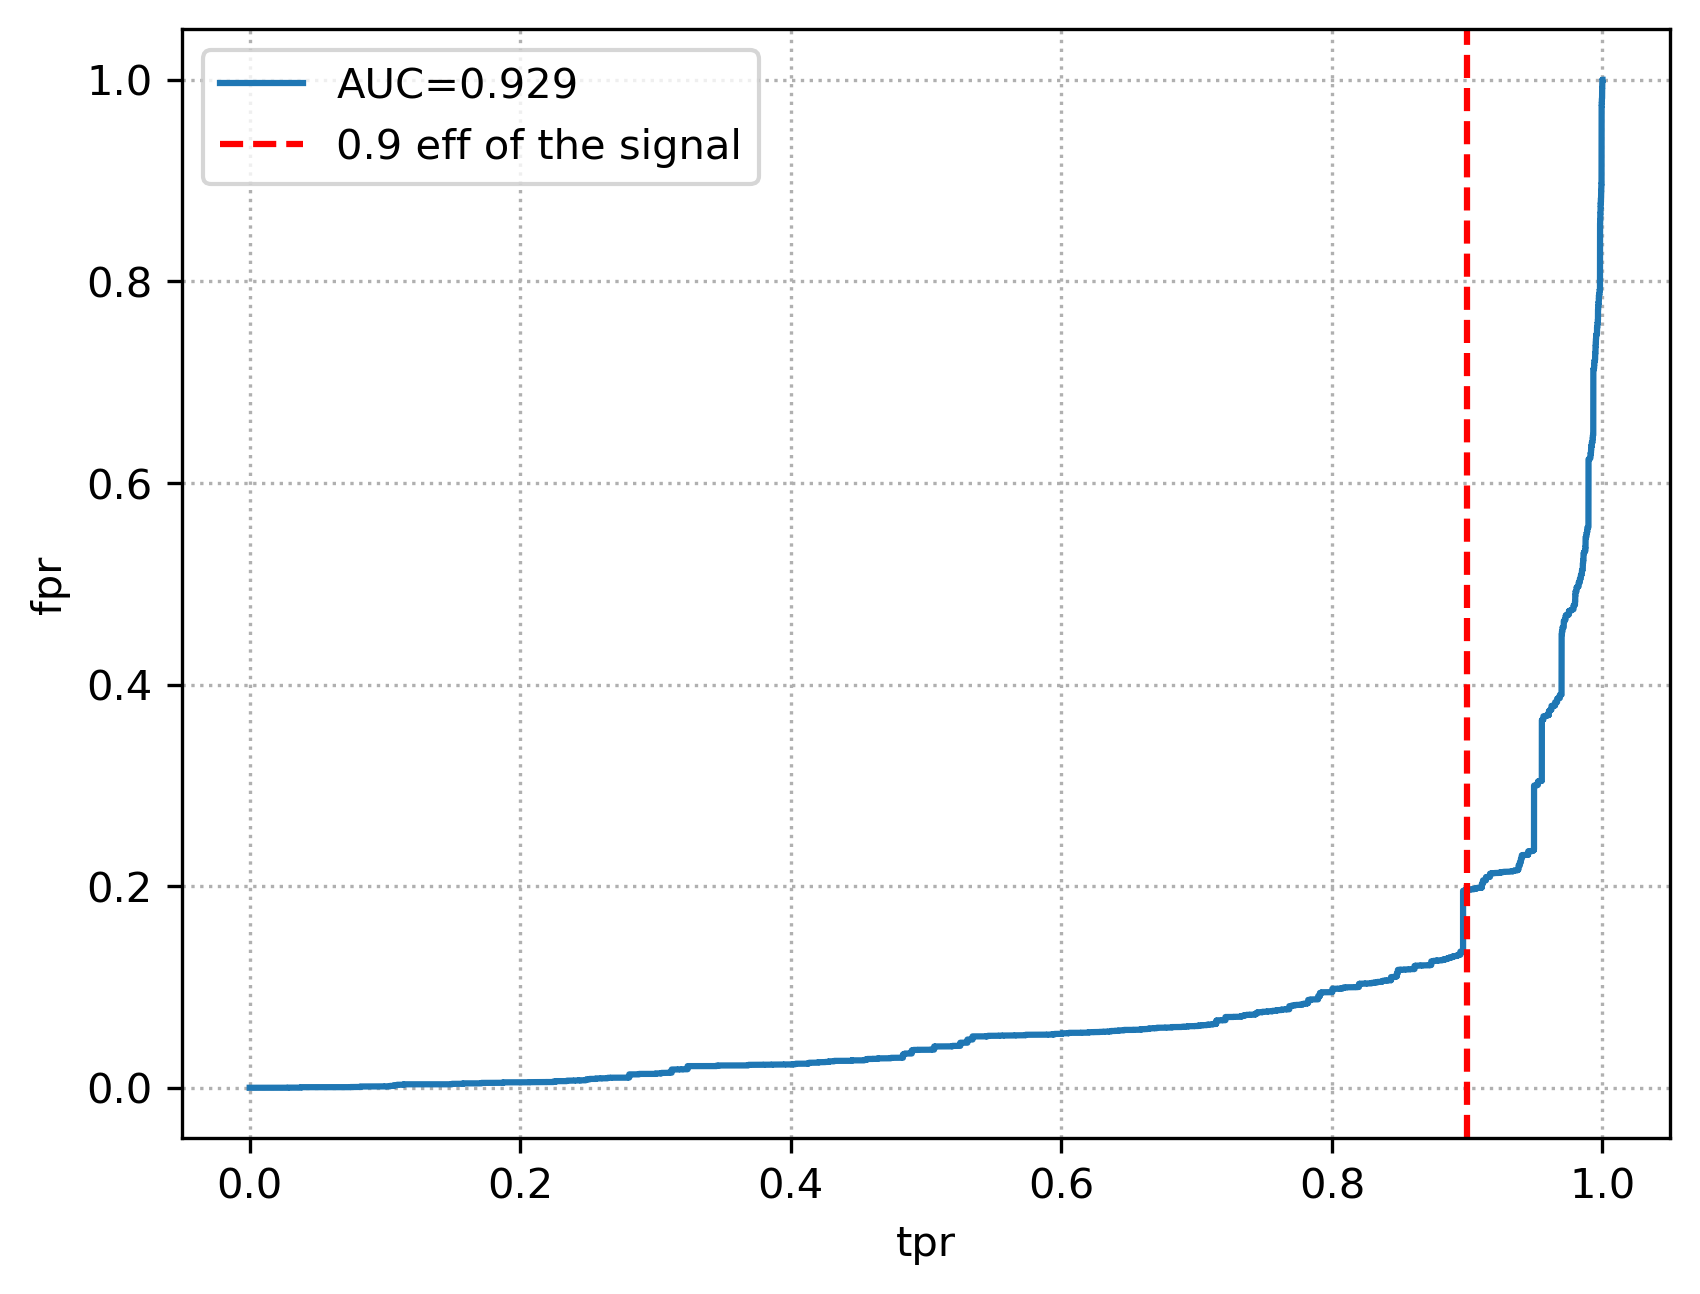

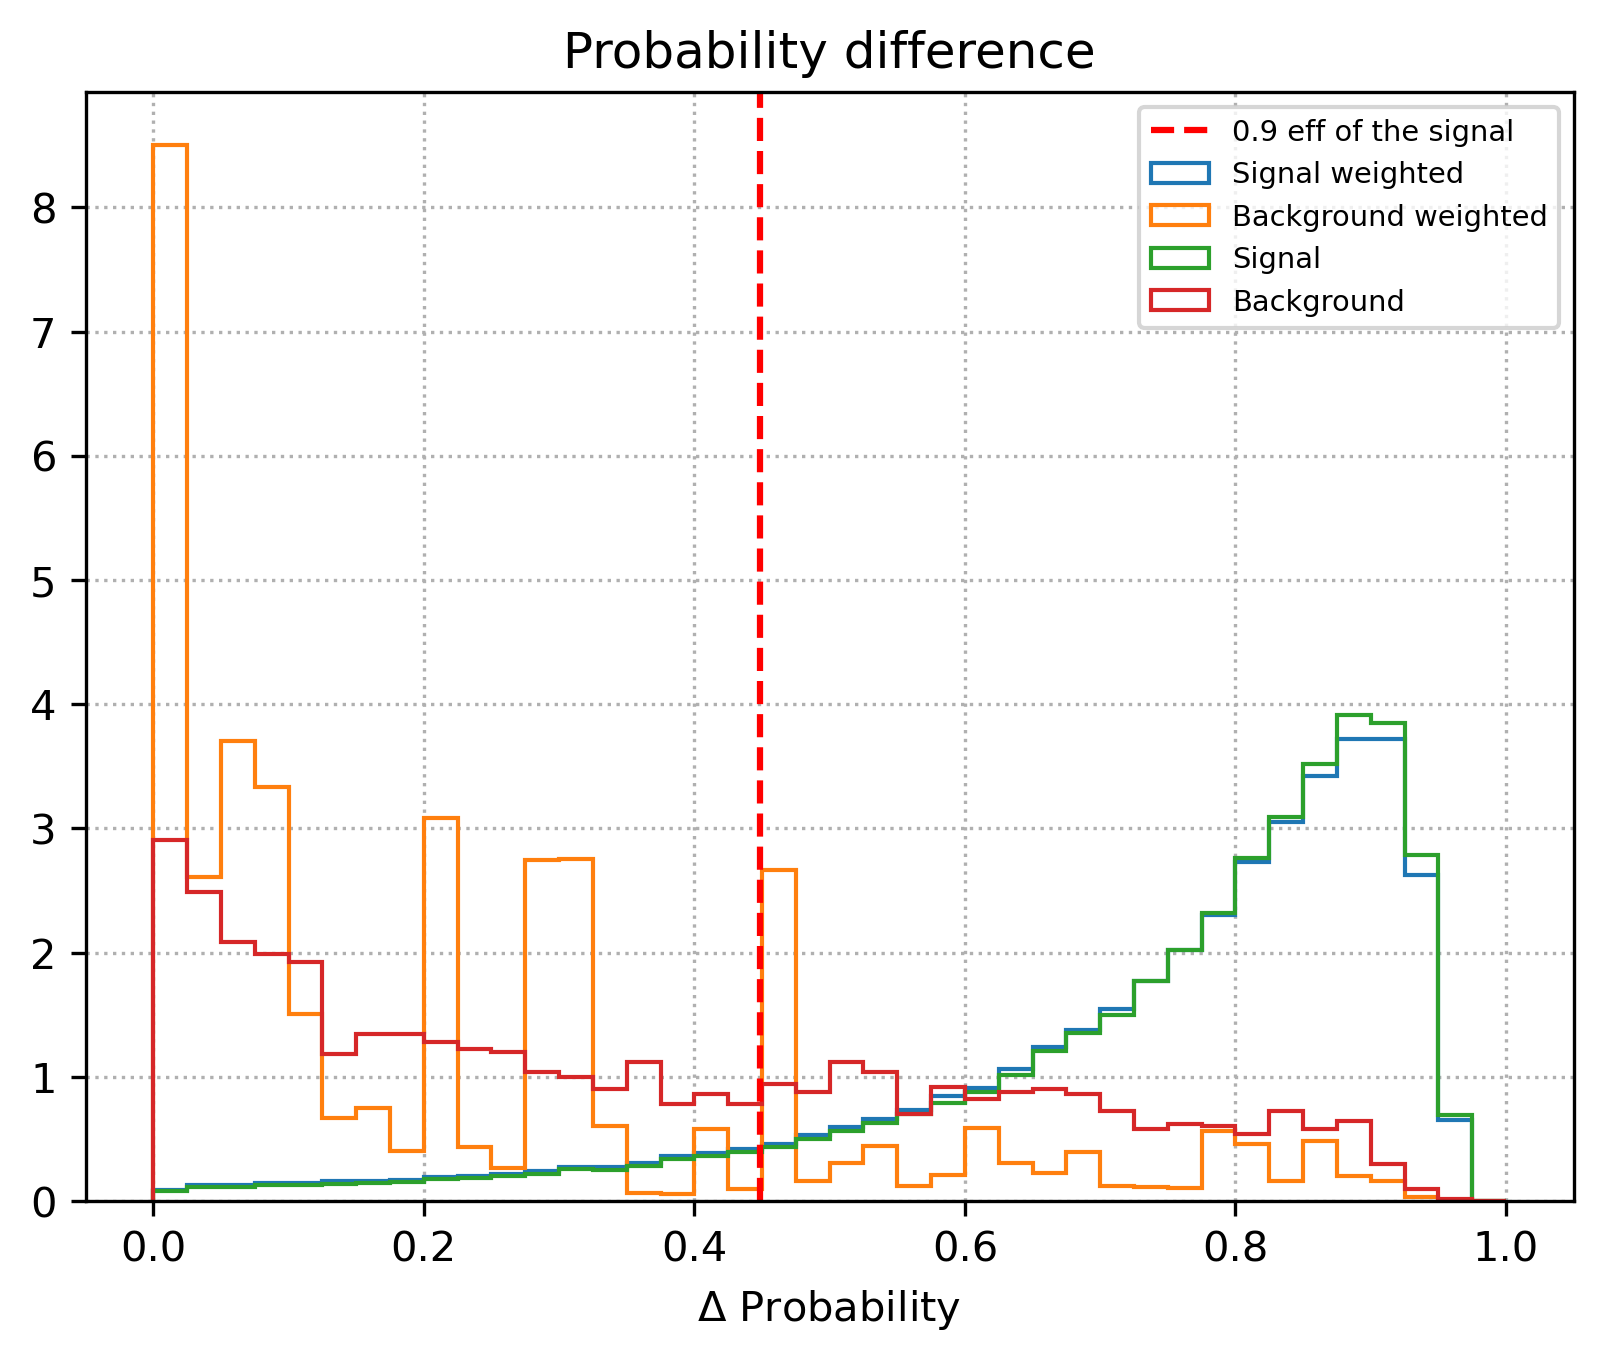

In [36]:
thresholds_check("spanet_pred_c_4b_QCD_sr_dnn.h5", "signal_region/signal_region_4b_QCD/output_JetGood_test.h5", 0.9, 1)

In [2]:
path_p= "/eos/home-r/ramellar/4_classification/classification_predictions/"
path_v= "/eos/home-r/ramellar/4_classification/variability_study"
path_i= "/eos/home-r/ramellar/5_inputs/"

def ratio_fpr(num, i_num, den, i_den,variability=None):
    
    if variability is not None:
        filename_test_num= path_i + i_num
        df_test_num= h5py.File(filename_test_num, "r")
        folder_path = f"/eos/home-r/ramellar/4_classification/variability_study/predictions/{num}"
        dataframes= load_h5_files_from_folder(folder_path)
        true_n= df_test_num["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_n= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in dataframes]
        weights_n= df_test_num["WEIGHTS"]['weight'][()]
        
        filename_test_den= path_i + i_den
        df_test_den= h5py.File(filename_test_den, "r")
        filename_pred_den= path_p + den
        df_pred_den= h5py.File(filename_pred_den, "r")
        
        true_d= df_test_den["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_d= df_pred_den["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_d= df_test_den["WEIGHTS"]['weight'][()]
        fp_array=np.array([])
        
        fpr_n, tpr_n, thresholds_n = zip(*[roc_curve(true_n, proba_signal_n[i], sample_weight=weights_n) for i in range(len(proba_signal_n))])
        fpr_d, tpr_d, thresholds_d = roc_curve(true_d, proba_signal_d, sample_weight=weights_d)
        
        print("len",len(fpr_n))
        fpr_d_int=interp1d(tpr_d,fpr_d)
        
        x2=np.linspace(0,0.4,10)
        x1=np.linspace(0.4,1,100)
        
        x=np.concatenate((x2,x1))
       
        spline_fpr_d= np.array(fpr_d_int(x))
            
        fpr_n_av=[]
        spline_variability=[]
        for i in range(len(fpr_n)):
            fpr_n_int=interp1d(tpr_n[i],fpr_n[i])
            # print("fpr", fpr_n_int)
            spline_fpr_n= np.array(fpr_n_int(x))
            # print("spline", len(spline_fpr_n))
            spline_variability.append(spline_fpr_n)
            # print("spline_variability", len(spline_variability))
    
        # fpr_n= spline_variability
        
        fpr_ratio= []
        
        for i in range(len(spline_variability)):
            btag_ratio_v= np.nan_to_num(spline_variability[i]/spline_fpr_d,0)
            print("btag_ratio_v", btag_ratio_v)
            fpr_ratio.append(btag_ratio_v)
            
        # fpr_n=np.array(fpr_n)
        # fpr_d= np.array(fpr_d)    
    
            
    else:
        filename_test_num= path_i + i_num
        df_test_num= h5py.File(filename_test_num, "r")
        filename_pred_num= path_p + num
        df_pred_num= h5py.File(filename_pred_num, "r")
        
        filename_test_den= path_i + i_den
        df_test_den= h5py.File(filename_test_den, "r")
        filename_pred_den= path_p + den
        df_pred_den= h5py.File(filename_pred_den, "r")
        
        true_n= df_test_num["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_n= df_pred_num["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_n= df_test_num["WEIGHTS"]['weight'][()]
           
        true_d= df_test_den["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_d= df_pred_den["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_d= df_test_den["WEIGHTS"]['weight'][()]
        
        fpr_n, tpr_n, thresholds_n = roc_curve(true_n, proba_signal_n, sample_weight=weights_n)
        fpr_d, tpr_d, thresholds_d = roc_curve(true_d, proba_signal_d, sample_weight=weights_d)
        
        fpr_n_int=interp1d(tpr_n,fpr_n)
        fpr_d_int=interp1d(tpr_d,fpr_d)
        
        x2=np.linspace(0,0.4,10)
        x1=np.linspace(0.4,1,100)
        
        x=np.concatenate((x2,x1))
        spline_fpr_n= np.array(fpr_n_int(x))
        spline_fpr_d= np.array(fpr_d_int(x))
        
        print(spline_fpr_n)
        
        fpr_ratio= np.nan_to_num(spline_fpr_n/spline_fpr_d,0)
        
    
    
    return fpr_ratio, fpr_n, fpr_d, tpr_n, tpr_d




In [3]:
model_ratio_dnn, fpr_2b_QCD_dnn, fpr_2b_data_dnn, tpr_2b_QCD_dnn, tpr_2b_data_dnn = ratio_fpr("spanet_c_4v_dnn_2b_QCD_new.h5", "spanet_classifier_2b_QCD/output_JetGood_test.h5", "spanet_c_4v_dnn_2b_data_out.h5", "spanet_classifier_2b_data/output_JetGood_test.h5")
# print(model_ratio_dnn)
btag_ratio_dnn, fpr_4b_QCD_dnn, fpr_2b_QCD, tpr_4b_QCD_dnn, tpr_2b_QCD_dnn = ratio_fpr("prediction__4b_QCD_dnn_vars_seeds/", "spanet_classifier_4b_QCD_working/output_JetGood_test.h5", "spanet_c_4v_dnn_2b_QCD_new.h5", "spanet_classifier_2b_QCD/output_JetGood_test.h5", True)
print("btag_ratio_dnn", len(btag_ratio_dnn))

[0.00000000e+00 1.18085213e-05 3.11893523e-04 4.39745614e-04
 1.08690869e-03 1.41224665e-03 6.01838566e-03 6.60957168e-03
 7.05812797e-03 8.27981647e-03 8.27981647e-03 8.39629141e-03
 8.44008866e-03 8.72008619e-03 8.82343320e-03 8.82630953e-03
 8.83777486e-03 9.10826650e-03 9.35126374e-03 9.40239651e-03
 9.42422096e-03 9.73149325e-03 9.77519889e-03 9.80956749e-03
 1.03167055e-02 1.05563032e-02 1.09319855e-02 1.58707877e-02
 1.61799670e-02 1.62351928e-02 1.62550010e-02 1.65274378e-02
 1.68511897e-02 1.73395810e-02 1.74616972e-02 1.76052299e-02
 1.77160013e-02 1.77827582e-02 1.78577985e-02 1.79166409e-02
 1.82280866e-02 1.83534835e-02 1.87044411e-02 2.31405134e-02
 2.33307535e-02 2.33878571e-02 2.35683132e-02 2.39117081e-02
 2.42306245e-02 2.43474560e-02 2.48906346e-02 2.59195042e-02
 2.62338488e-02 2.64961163e-02 2.66330485e-02 2.68382178e-02
 2.71442541e-02 2.79036432e-02 2.81117045e-02 2.89627690e-02
 2.95349261e-02 3.03725506e-02 3.56067363e-02 3.60199395e-02
 3.69067537e-02 3.695926

/tmp/ramellar/ipykernel_698186/2431683037.py:96: RuntimeWarning: invalid value encountered in true_divide
  fpr_ratio= np.nan_to_num(spline_fpr_n/spline_fpr_d,0)


NameError: name 'load_h5_files_from_folder' is not defined

In [ ]:
path_p= "/eos/home-r/ramellar/4_classification/classification_predictions/"
path_v= "/eos/home-r/ramellar/4_classification/variability_study"
path_i= "/eos/home-r/ramellar/5_inputs/"

def load_h5_files_from_folder(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    # Filter out the h5 files
    h5_files = [f for f in files if f.endswith('.h5')]

    # Initialize an empty list to store dataframes
    dataframes = []

    # Loop through each h5 file and read it into a dataframe
    for h5_file in h5_files:
        file_path = os.path.join(folder_path, h5_file)
        df =  h5py.File(file_path, "r")
        dataframes.append(df)
        # print(f"Loaded {h5_file}")

    return dataframes

In [ ]:
def ratio_fpr(num, i_num, den, i_den, variability=None):
    
    if variability is not None:
        filename_test_num= path_i + i_num
        df_test_num= h5py.File(filename_test_num, "r")
        folder_path = f"/eos/home-r/ramellar/4_classification/variability_study/predictions/{num}"
        dataframes= load_h5_files_from_folder(folder_path)
        true_n= df_test_num["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_n= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in dataframes]
        weights_n= df_test_num["WEIGHTS"]['weight'][()]
        
        print(len(proba_signal_n))
        
        filename_test_den= path_i + i_den
        df_test_den= h5py.File(filename_test_den, "r")
        filename_pred_den= path_p + den
        df_pred_den= h5py.File(filename_pred_den, "r")
        
        true_d= df_test_den["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_d= df_pred_den["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_d= df_test_den["WEIGHTS"]['weight'][()]
        fp_array=np.array([])
        
        fpr_n, tpr_n, thresholds_n = zip(*[roc_curve(true_n, proba_signal_n[i], sample_weight=weights_n) for i in range(len(proba_signal_n))])
        fpr_d, tpr_d, thresholds_d = roc_curve(true_d, proba_signal_d, sample_weight=weights_d)
        
        print(type(fpr_n))
        print(type(fpr_n[0]))
        
        fpr_d= np.array(fpr_d)
        fpr_n= np.array(fpr_n, dtype=object)
        
        print(len(fpr_n))
        print(len(fpr_n[0]))
        
        btag_fpr_ratio= [fpr_n[i]/fpr_d for i in range(len(fpr_n))]
        
    else:
        filename_test_num= path_i + i_num
        df_test_num= h5py.File(filename_test_num, "r")
        filename_pred_num= path_p + num
        df_pred_num= h5py.File(filename_pred_num, "r")
        
        filename_test_den= path_i + i_den
        df_test_den= h5py.File(filename_test_den, "r")
        filename_pred_den= path_p + den
        df_pred_den= h5py.File(filename_pred_den, "r")
        
        true_n= df_test_num["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_n= df_pred_num["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_n= df_test_num["WEIGHTS"]['weight'][()]
        print("proba_signal_n",len(proba_signal_n))
        
        
        true_d= df_test_den["CLASSIFICATIONS"]["EVENT"]["signal"][()]
        proba_signal_d= df_pred_den["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
        weights_d= df_test_den["WEIGHTS"]['weight'][()]
        print("proba_signal_d",len(proba_signal_d))
        print(len(np.unique(proba_signal_d)))
        
        fpr_n, tpr_n, thresholds_n = roc_curve(true_n, proba_signal_n, sample_weight=weights_n)
        fpr_d, tpr_d, thresholds_d = roc_curve(true_d, proba_signal_d, sample_weight=weights_d)
        
        print("fpr_n", len(fpr_n))
        print("fpr_d", len(fpr_d))
        
        fpr_n=np.array(fpr_n)
        fpr_d=np.array(fpr_d)
        
        fpr_n_red=
        
        btag_fpr_ratio
    
    return btag_fpr_ratio


SyntaxError: invalid syntax (215643794.py, line 70)

In [ ]:
btag_fpr_ratio = ratio_fpr("spanet_c_4v_dnn_2b_QCD_new.h5", "spanet_classifier_2b_QCD/output_JetGood_test.h5", "spanet_c_4v_dnn_proba_2b_data_out.h5", "spanet_classifier_2b_data/output_JetGood_test.h5")


NameError: name 'ratio_fpr' is not defined

In [ ]:
import numpy as np

m = 3
a = np.array([2, 3, 4, 8, 9])
b = a.reshape(-1, m).mean(axis=1)
#array([3., 9.])

print(b)

ValueError: cannot reshape array of size 5 into shape (3)

In [ ]:
import numpy as np
from functools import reduce

''' Function to find factors of a given number 'n' '''
def factors(n):    
    return list(set(reduce(list.__add__, 
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

a = [2,3,4,8,9]  #Given array.

'''fac: list of factors of length of a. 
   In this example, len(a) = 6. So, fac = [1, 2, 3, 6] '''
fac = factors(len(a)) 

'''step: choose an appropriate step size from the list 'fac'.
   In this example, we choose one of the middle numbers in fac 
   (3). '''   
step = fac[int( len(fac)/3 )+1]

'''avg: initialize an empty array. '''
avg = np.array([])
for i in range(0, len(a), step):
    avg = np.append( avg, np.mean(a[i:i+step]) ) #append averaged values to `avg`

print(avg)  #Prints the final result

[5.2]


In [ ]:
def factors(n):    
    return list(set(reduce(list.__add__, 
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))
   
n=5 
for i in range(1, int(n**0.5) + 1):
    print(i)
    print(n % i)
    if n % i == 0:
        print(int(n**0.5)+1)
        print([i, n//i])
    
fac=factors(71147)

1
0
3
[1, 5]
2
1


In [ ]:
step = fac[int( len(fac)/3 )+1]

print(int( len(fac)/3 )+1)

print(step)
print(fac)



1
71147
[1, 71147]


In [ ]:
import awkward as ak
from functools import reduce

''' Function to find factors of a given number 'n' '''
def factors(n):    
    return list(set(reduce(list.__add__, 
        ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

a =[2,3,4,8,9]#Given array.
# a =[2,9]#Given array.


'''fac: list of factors of length of a. 
   In this example, len(a) = 6. So, fac = [1, 2, 3, 6] '''
fac = factors(len(a)) 
print(fac)

'''step: choose an appropriate step size from the list 'fac'.
   In this example, we choose one of the middle numbers in fac 
   (3). '''   
step = fac[int( len(fac)/3 )+1]
print(step)

'''avg: initialize an empty array. '''
avg = np.array([])
for i in range(0, len(a), step):
    avg = np.append( avg, np.mean(a[i:i+step]) ) #append averaged values to `avg`

print(avg)  #Prints the final result

[1, 5]
5
[5.2]


In [ ]:
def mean_element(array, counts):
    array=ak.Array(array)
    array_unflatten=ak.unflatten(array,counts)
    print(array_unflatten)
    fac = [factors(len(a)) for a in array_unflatten] 
    print(fac)
    step = [fac[i][int(len(fac[i])/3 )+1] for i in len(fac)]
    
    avg = ak.Array([])
    
    for j in range(len(array_unflatten)):
        for i in range(0, len(a[j]), step):
            avg = np.append( avg, ak.mean(a[i:i+step]) )
        
    return avg

a =[2,3,4,8,9]
mean_element(a , 3)

[[2, 3, 4]]
[[1, 3]]


TypeError: 'int' object is not iterable

In [ ]:
import awkward as ak
import numpy as np
from functools import reduce

# Function to find factors of a given number 'n'
def factors(n):
    return list(set(reduce(list.__add__,
        ([i, n // i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

def mean_element(array, count):
    array = ak.Array(array)
    array_unflatten = ak.unflatten(array, count)
    
    # Print unflattened array for debugging
    print("Unflattened array:", array_unflatten)
    
    fac = [factors(len(a)) for a in array_unflatten]
    
    # Print factors for debugging
    print("Factors of lengths:", fac)
    
    # Calculate the appropriate step size for each sub-array
    steps = [f[int(len(f)/3)] for f in fac]
    
    # Print steps for debugging
    print("Steps:", steps)
    
    avg = []
    
    for j, sub_array in enumerate(array_unflatten):
        step = steps[j]
        means = [np.mean(sub_array[i:i + step]) for i in range(0, len(sub_array), step)]
        avg.extend(means)
    
    return ak.Array(avg)

# Example usage
a = [2, 3, 4, 8, 9]
counts = 3
result = mean_element(a, counts)
print("Result:", result)


Unflattened array: [[2, 3, 4]]
Factors of lengths: [[1, 3]]
Steps: [1]
Result: [2, 3, 4]


In [ ]:
import awkward as ak
import numpy as np

def mean_element(array, count):
    array = ak.Array(array)
    num_elements = len(array)
    
    # Calculate the number of complete sub-arrays
    num_full_sub_arrays = num_elements // count
    remaining_elements = num_elements % count
    
    # Split the array into full sub-arrays and the remaining elements
    full_sub_arrays = array[:num_full_sub_arrays * count].to_numpy().reshape(-1, count)
    remaining_chunk = array[num_full_sub_arrays * count:] if remaining_elements > 0 else []
    
    # Print full chunks and remaining chunk for debugging
    print("Full chunks:", full_sub_arrays)
    print("Remaining chunk:", remaining_chunk)
    
    # Calculate the mean of each full sub-array
    avg = [np.mean(sub_array) for sub_array in full_sub_arrays]
    
    # Calculate the mean of the remaining elements, if any
    if remaining_elements > 0:
        avg.append(np.mean(remaining_chunk))
    
    # Return the resulting array of means
    return ak.Array(avg)

# Example usage
a = [2, 3, 4, 8, 9, 6, 7, 8, 8, 8]
counts = 3
result = mean_element(a, counts)
print("Result:", result)


Full chunks: [[2 3 4]
 [8 9 6]
 [7 8 8]]
Remaining chunk: [8]
Result: [3, 7.67, 7.67, 8]


In [ ]:
import random

# Define the length of the list
list_length = 71147
list_length_2 = 53046

# Generate a list of random integers between 1 and 100
random_list = [random.randint(1, 100) for _ in range(list_length)]
random_list_2 = [random.randint(1, 100) for _ in range(list_length_2)]

# Print the length of the list (optional)
print("Length of the list:", len(random_list))

# Print the first few elements of the list (optional)
print("First 10 elements:", random_list[:10])

counts = 3
result = mean_element(random_list, counts)
print("Result:", len(result))
counts = 3
result_2 = mean_element(random_list_2, counts)
print("Result:", len(result_2))




Length of the list: 71147
First 10 elements: [6, 42, 10, 31, 29, 50, 8, 80, 100, 66]
Full chunks: [[  6  42  10]
 [ 31  29  50]
 [  8  80 100]
 ...
 [ 75  75  70]
 [ 33  50  45]
 [ 22   7  18]]
Remaining chunk: [81, 68]
Result: 23716
Full chunks: [[66 72 48]
 [22  6 28]
 [55  5  5]
 ...
 [17 68 73]
 [84 94 10]
 [88 36 88]]
Remaining chunk: []
Result: 17682


In [ ]:
import awkward as ak
import numpy as np
from math import ceil

def split_and_average(array, chunk_size):
    array = ak.Array(array)
    num_elements = len(array)
    
    # Calculate the number of complete chunks
    num_full_chunks = num_elements // chunk_size
    remaining_elements = num_elements % chunk_size
    
    # Split the array into full chunks and the remaining elements
    full_chunks = array[:num_full_chunks * chunk_size].to_numpy().reshape(-1, chunk_size)
    remaining_chunk = array[num_full_chunks * chunk_size:] if remaining_elements > 0 else []
    
    # Calculate the mean of each full chunk
    avg = [np.mean(chunk) for chunk in full_chunks]
    
    # Calculate the mean of the remaining elements, if any
    if remaining_elements > 0:
        avg.append(np.mean(remaining_chunk))
    
    # Return the resulting array of means
    return ak.Array(avg)

def find_common_chunk_size(len1, len2):
    # Find the smallest chunk size that allows both arrays to be split into the same number of sub-arrays
    for chunk_size in range(1, min(len1, len2) + 1):
        if ceil(len1 / chunk_size) == ceil(len2 / chunk_size):
            return chunk_size
    return 1  # Default to 1 if no other common chunk size is found

def same_lenght(len1,len2, array1, array2):
    for chunk_size1, chunk_size2 in range(1, min(len1, len2) + 1):
        a=split_and_average(array1, chunk_size1)
        b=split_and_average(array2, chunk_size2)
        if len(a)==len(b):
            print(chunk_size1,chunk_size2)
        

def equalize_arrays(array1, array2):
    len1 = len(array1)
    len2 = len(array2)
    
    # Find the common chunk size
    chunk_size = find_common_chunk_size(len1, len2)
    print(chunk_size)
    
    mean1 = split_and_average(array1, chunk_size)
    mean2 = split_and_average(array2, chunk_size)
    
    return mean1, mean2

# Example usage
array1 = [2, 3, 4, 8, 9, 6, 7, 8, 8, 8]
array2 = [1, 2, 3, 4, 5, 6, 7]

mean1, mean2 = equalize_arrays(array1, array2)
print("Means of array1:", mean1)
print("Means of array2:", mean2)


5
Means of array1: [5.2, 7.4]
Means of array2: [3, 6.5]


In [ ]:
def calculate_chunk_size(array_length):
    # Calculate the chunk size that results in sub-arrays of approximately equal size
    chunk_size = array_length // ((array_length + 1) // 2)
    return chunk_size

# Example usage
array_length = 10  # Replace with the actual length of your array
chunk_size = calculate_chunk_size(array_length)
print(f"Chunk size for array of length {array_length}:", chunk_size)


In [ ]:
import awkward as ak
import numpy as np

def split_and_average(array, chunk_size):
    array = ak.Array(array)
    num_elements = len(array)
    
    # Calculate the number of complete chunks
    num_full_chunks = num_elements // chunk_size
    remaining_elements = num_elements % chunk_size
    
    # Split the array into full chunks and the remaining elements
    full_chunks = array[:num_full_chunks * chunk_size].to_numpy().reshape(-1, chunk_size)
    remaining_chunk = array[num_full_chunks * chunk_size:] if remaining_elements > 0 else []
    
    # Calculate the mean of each full chunk
    avg = [np.mean(chunk) for chunk in full_chunks]
    
    # Calculate the mean of the remaining elements, if any
    if remaining_elements > 0:
        avg.append(np.mean(remaining_chunk))
    
    # Return the resulting array of means
    return ak.Array(avg)

def same_length(len1, len2, array1, array2):
    # Iterate over possible chunk sizes for both arrays
    for chunk_size1 in range(1, min(len1, len2) + 1):
        for chunk_size2 in range(1, min(len1, len2) + 1):
            # Calculate the averages for both arrays with current chunk sizes
            avg1 = split_and_average(array1, chunk_size1)
            avg2 = split_and_average(array2, chunk_size2)
            
            # Check if both arrays have the same length after averaging
            if len(avg1) == len(avg2):
                return chunk_size1, chunk_size2  # Return the chunk sizes
    return None  # Return None if no matching chunk sizes found

# Example usage
array1 = [2, 3, 4, 8, 9, 6, 7, 8, 8, 8]
array2 = [1, 2, 3, 4, 5, 6, 7]

len1 = len(array1)
len2 = len(array2)

chunk_size1, chunk_size2 = same_length(len1, len2, array1, array2)
if chunk_size1 is not None and chunk_size2 is not None:
    print(f"Chunk sizes for array1: {chunk_size1}, array2: {chunk_size2}")
else:
    print("No matching chunk sizes found.")


Chunk sizes for array1: 3, array2: 2


In [ ]:
def same_length(len1, len2, array1, array2):
    # Define a reasonable range for chunk sizes
    max_chunk_size = min(len1, len2)
    min_chunk_size = 1  # Start from chunk size 1
    
    for chunk_size1 in range(min_chunk_size, max_chunk_size + 1):
        for chunk_size2 in range(min_chunk_size, max_chunk_size + 1):
            # Calculate the averages for both arrays with current chunk sizes
            avg1 = split_and_average(array1, chunk_size1)
            avg2 = split_and_average(array2, chunk_size2)
            
            # Check if both arrays have the same length after averaging
            if len(avg1) == len(avg2):
                return chunk_size1, chunk_size2  # Return the chunk sizes
    return None  # Return None if no matching chunk sizes found


In [ ]:
import random
import numpy as np
import awkward as ak

# Function to calculate the mean elements and return the resulting array
def mean_element(array, count):
    array = ak.Array(array)
    num_elements = len(array)
    
    # Calculate the number of complete sub-arrays
    num_full_sub_arrays = num_elements // count
    remaining_elements = num_elements % count
    
    # Split the array into full sub-arrays and the remaining elements
    full_sub_arrays = array[:num_full_sub_arrays * count].to_numpy().reshape(-1, count)
    remaining_chunk = array[num_full_sub_arrays * count:] if remaining_elements > 0 else []
    
    # Calculate the mean of each full sub-array
    avg = [np.mean(sub_array) for sub_array in full_sub_arrays]
    
    # Calculate the mean of the remaining elements, if any
    if remaining_elements > 0:
        avg.append(np.mean(remaining_chunk))
    
    # Return the resulting array of means
    return ak.Array(avg)

# Define the length of the lists
list_length = 71147
list_length_2 = 53046

# Generate random lists
random_list = [random.randint(1, 100) for _ in range(list_length)]
random_list_2 = [random.randint(1, 100) for _ in range(list_length_2)]

# Desired number of events in the resulting arrays
desired_events = len(mean_element(random_list_2, 6))

# Find suitable chunk sizes for random_list
for counts in range(1, list_length + 1):
    result = mean_element(random_list, counts)
    if len(result) == desired_events:
        print(f"Chunk size for random_list: {counts}")
        break

# Find suitable chunk sizes for random_list_2
for counts in range(1, list_length_2 + 1):
    result_2 = mean_element(random_list_2, counts)
    if len(result_2) == desired_events:
        print(f"Chunk size for random_list_2: {counts}")
        break


KeyboardInterrupt: 

In [ ]:
import random
import numpy as np
import awkward as ak

# Function to calculate the mean elements and return the resulting array
def mean_element(array, count):
    array = ak.Array(array)
    num_elements = len(array)
    
    # Calculate the number of complete sub-arrays
    num_full_sub_arrays = num_elements // count
    remaining_elements = num_elements % count
    
    # Split the array into full sub-arrays and the remaining elements
    full_sub_arrays = array[:num_full_sub_arrays * count].to_numpy().reshape(-1, count)
    remaining_chunk = array[num_full_sub_arrays * count:] if remaining_elements > 0 else []
    
    # Calculate the mean of each full sub-array
    avg = [np.mean(sub_array) for sub_array in full_sub_arrays]
    
    # Calculate the mean of the remaining elements, if any
    if remaining_elements > 0:
        avg.append(np.mean(remaining_chunk))
    
    # Return the resulting array of means
    return ak.Array(avg)

# Define the length of the lists
list_length = 71147
list_length_2 = 53046

# Generate random lists
random_list = [random.randint(1, 100) for _ in range(list_length)]
random_list_2 = [random.randint(1, 100) for _ in range(list_length_2)]

# Desired number of events in the resulting arrays
desired_events = 4

# Function to find chunk size using binary search
def find_chunk_size(array_length, desired_events):
    low, high = 1, array_length
    best_counts = None
    
    while low <= high:
        mid = (low + high) // 2
        result = mean_element(random_list, mid)
        if len(result) == desired_events:
            best_counts = mid
            high = mid - 1  # Look for smaller chunk sizes
        elif len(result) < desired_events:
            low = mid + 1  # Look for larger chunk sizes
        else:
            high = mid - 1  # Look for smaller chunk sizes
    
    return best_counts

# Find suitable chunk sizes for random_list
counts_random_list = find_chunk_size(list_length, desired_events)
print(f"Chunk size for random_list: {counts_random_list}")

# Find suitable chunk sizes for random_list_2
counts_random_list_2 = find_chunk_size(list_length_2, desired_events)
print(f"Chunk size for random_list_2: {counts_random_list_2}")


Chunk size for random_list: None
Chunk size for random_list_2: None


In [ ]:
#Define my lists
list_length = 67496
list_length_2 = 53046

random_list = [random.randint(1, 100) for _ in range(list_length)]
random_list_2 = [random.randint(1, 100) for _ in range(list_length_2)]

# Desired number of events in the resulting arrays
desired_events = 1000

step_1= int(len(random_list)/desired_events)
step_2= int(len(random_list_2)/desired_events)


def mean_element(array, desired_events):
    array = ak.Array(array)
    count=int(len(array)//desired_events)
    print(len(array)/desired_events)
    
    print(count)
    print("resto",len(array) % desired_events)
    
    length= np.ones(desired_events, dtype= int)* (count)
    stop=(len(array)- (desired_events*count))
    #probalem with this multipliivcayion by 2 but if we remove it does not work
    #problem is that before we where having values less tah 5000 so wheen multiplied by 2 they are not a pb
    #we need to find a solution for values superior to 5000
    print(len(array))
    print(desired_events)
    print(count)
    print(stop)
    index=np.arange(0,stop, 1)
    print(len(length))
    length[index]=count+1
    print(sum(length))
    
    print("resto",len(array) % desired_events)
    
    array_unflatten=ak.unflatten(array, length)
    
    print(len(array_unflatten))
    print(array_unflatten[:2])
    
    avg=ak.mean(array_unflatten, axis=1)
    
    return ak.Array(avg)

array_1_avg= mean_element(random_list, 10000)
# array_2_avg= mean_element(random_list_2, step_2)

print(len(array_1_avg))
print((array_1_avg[:2]))
# print(len(array_2_avg))





6.7496
6
resto 7496
67496
10000
6
7496
10000
67496
resto 7496
10000
[[49, 46, 6, 65, 99, 8, 46], [89, 22, 52, 94, 98, 75, 19]]
10000
[45.6, 64.1]


In [ ]:
list1= np.array([45, 77, 27, 75, 70, 70, 63, 5])
np.mean(list1)

54.0